In [1]:
import pandas as pd
import numpy as np

In [2]:
bkk_pm_filled = pd.read_csv("../../data/a1/bkk_pm_filled.csv", parse_dates=["date"])

bkk_pm_filled.drop(columns=["avg"], inplace=True)

In [3]:
bkk_pm_filled

,date,temperature_min,dew_point_avg,humidity_avg,wind_speed_max,pressure_max
0,2011-05-31,68.774194,74.629032,73.600000,14.161290,29.806452
1,2011-06-30,73.766667,74.066667,72.106667,17.966667,29.756667
2,2011-07-31,70.483871,73.803226,74.603226,15.354839,29.764516
3,2011-08-31,75.580645,73.783871,74.232258,14.935484,29.787097
4,2011-09-30,67.400000,73.633333,75.316667,15.233333,29.786667
...,...,...,...,...,...,...
159,2024-08-31,77.193548,75.390323,73.041935,14.967742,29.816129
160,2024-09-30,79.200000,75.580000,75.266667,15.200000,29.783333
161,2024-10-31,78.967742,75.712903,76.603226,13.129032,29.864516
162,2024-11-30,78.233333,71.273333,66.146667,11.500000,29.890000


In [4]:
feature_list = [col for col in bkk_pm_filled.columns if col != 'date']

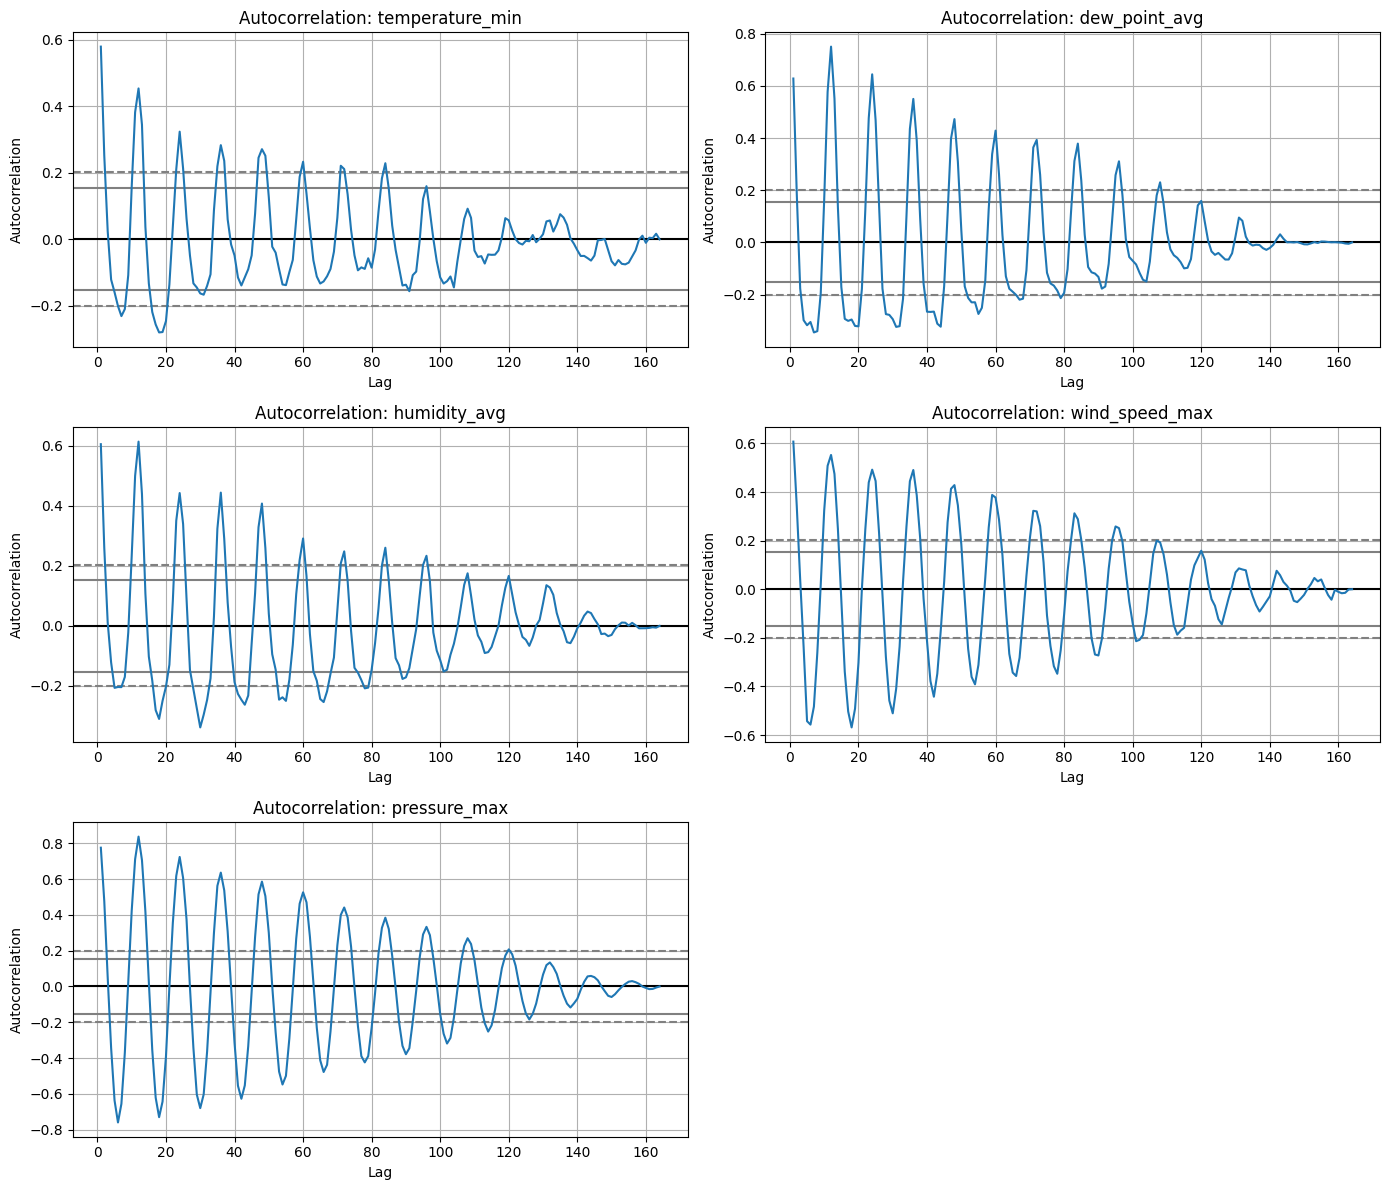

In [5]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# Plot autocorrelation for each feature
for i, feature in enumerate(feature_list):
    autocorrelation_plot(bkk_pm_filled[feature].dropna(), ax=axes[i])
    axes[i].set_title(f'Autocorrelation: {feature}')

# Hide unused subplot if any
for j in range(len(feature_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

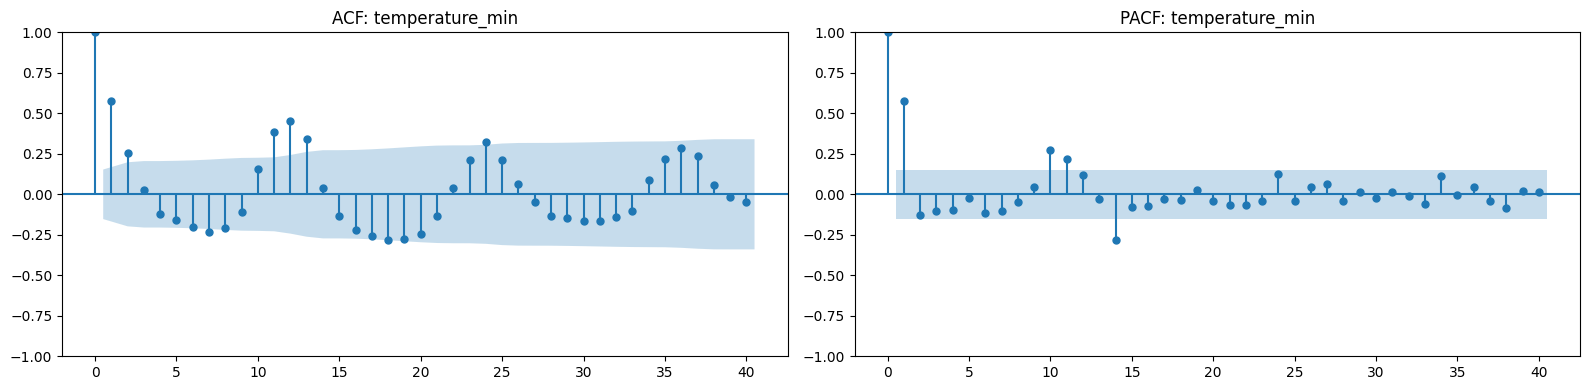

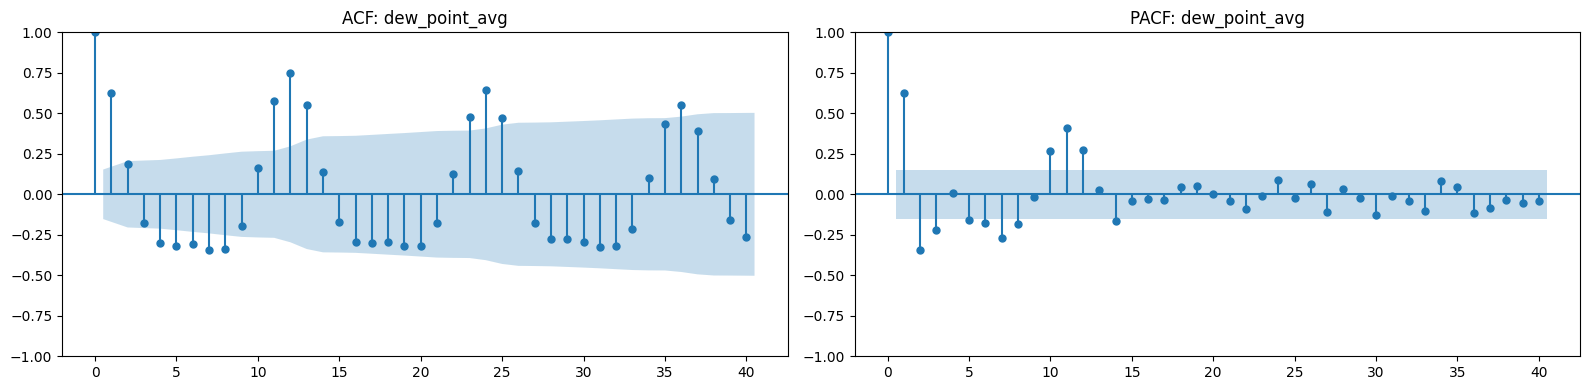

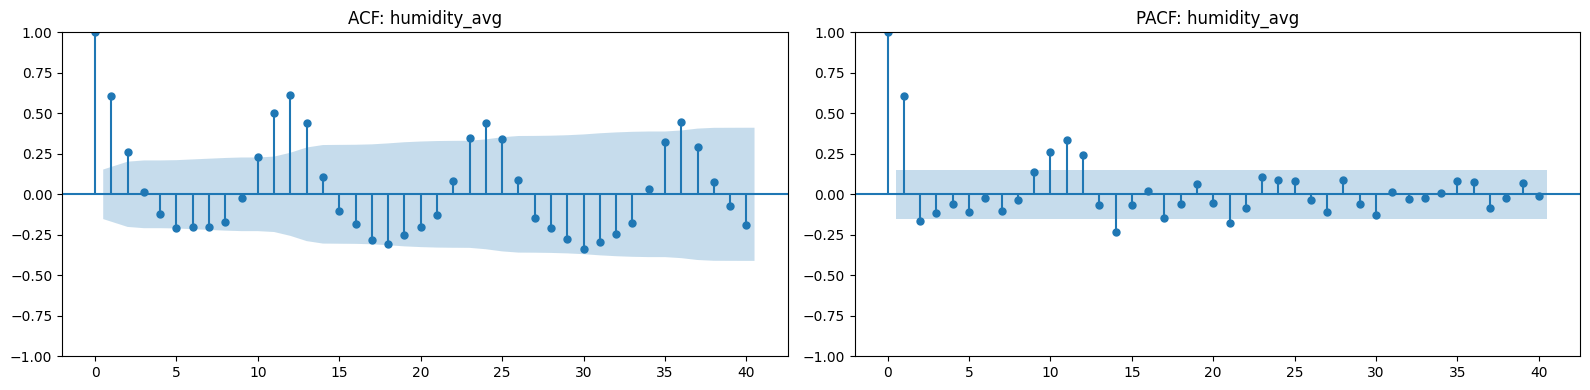

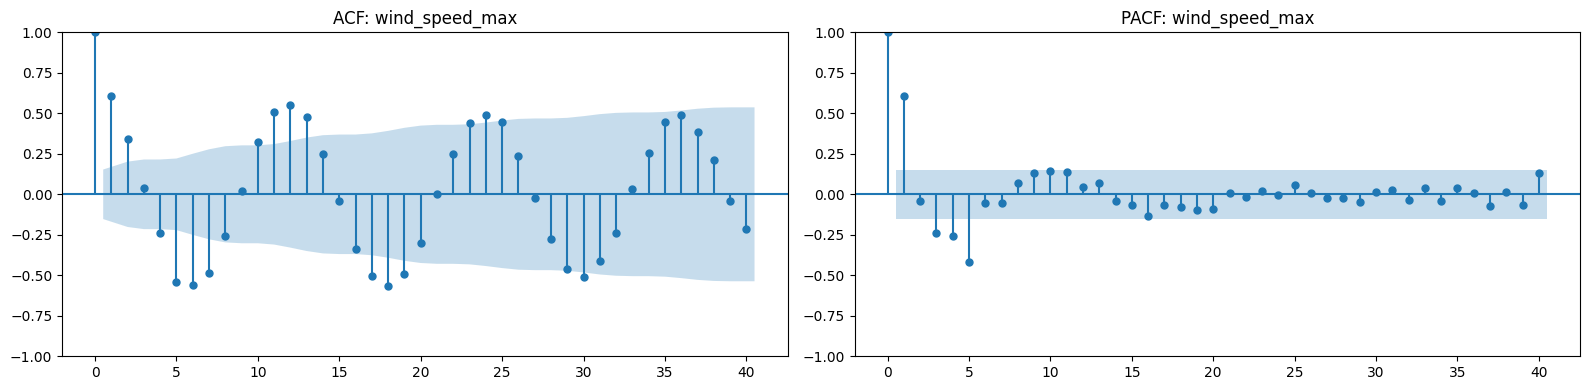

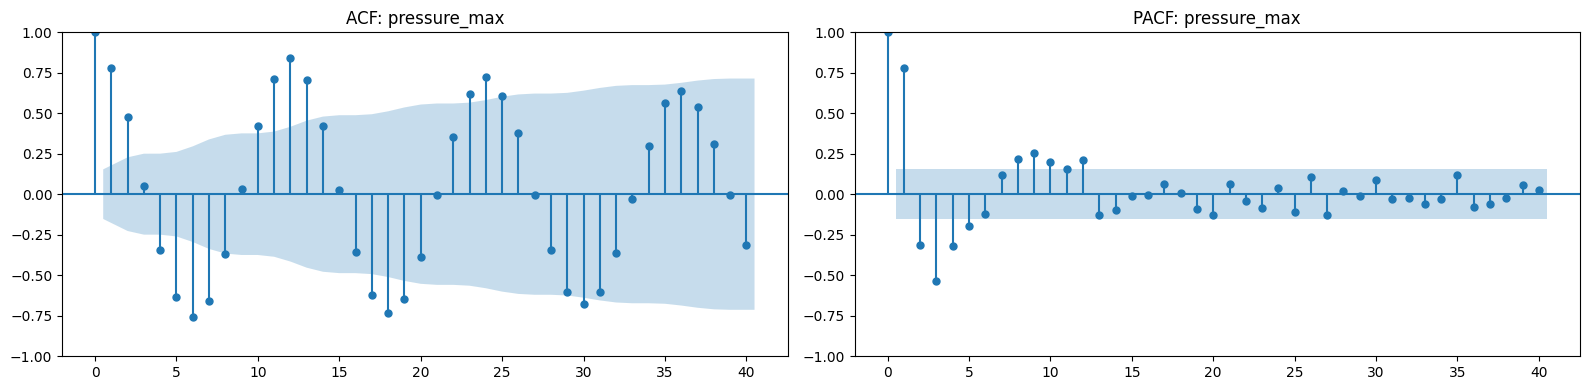

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
n_lags = 40

for feature in feature_list:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # ACF plot
    plot_acf(bkk_pm_filled[feature].dropna(), ax=axes[0], lags=n_lags)
    axes[0].set_title(f'ACF: {feature}')

    # PACF plot
    plot_pacf(bkk_pm_filled[feature].dropna(), ax=axes[1], lags=n_lags, method='ywm')
    axes[1].set_title(f'PACF: {feature}')

    plt.tight_layout()
    plt.show()


In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:
for feature in feature_list:
    y = bkk_pm_filled[feature].dropna()
    
    # Ensure the data has a datetime index
    if not isinstance(y.index, pd.DatetimeIndex):
        y.index = pd.to_datetime(bkk_pm_filled.loc[y.index, "date"])


In [16]:
# Define the forecast horizon (number of steps for future predictions)
forecast_steps = 12

# Split the data into training and test sets
y_train = y[:-forecast_steps]
y_test = y[-forecast_steps:]


In [17]:
# Fit SARIMA model to the training data
model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [18]:
# Generate forecast for the defined number of steps
forecast = result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Generate forecast index (same index as test set)
forecast_index = pd.date_range(start=y_train.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')
forecast_mean.index = forecast_index
y_test.index = forecast_index  # Ensure alignment

In [19]:
# Generate forecast for the defined number of steps
forecast = result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Generate forecast index (same index as test set)
forecast_index = pd.date_range(start=y_train.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')
forecast_mean.index = forecast_index
y_test.index = forecast_index  # Ensure alignment

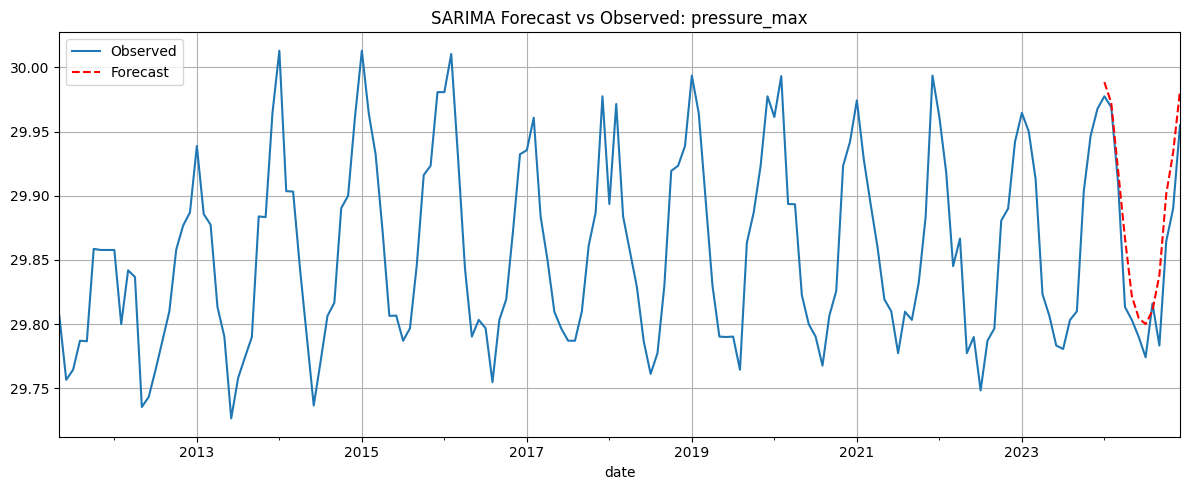

In [20]:
# Plot the observed and forecasted values
fig, ax = plt.subplots(figsize=(12, 5))
y.plot(ax=ax, label='Observed')
forecast_mean.plot(ax=ax, label='Forecast', color='red', style='--')
ax.set_title(f'SARIMA Forecast vs Observed: {feature}')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Print the forecasted values
print(f"Forecasted values for {feature}:")
print(forecast_mean)

Forecasted values for pressure_max:
2024-01-01    29.988490
2024-02-01    29.972305
2024-03-01    29.919500
2024-04-01    29.866671
2024-05-01    29.821694
2024-06-01    29.804778
2024-07-01    29.799966
2024-08-01    29.810697
2024-09-01    29.837996
2024-10-01    29.901259
2024-11-01    29.933580
2024-12-01    29.981645
Freq: MS, Name: predicted_mean, dtype: float64


In [23]:
# Define evaluation metrics (MAE, RMSE, MAPE, R²)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(y_test, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
mape = mean_absolute_percentage_error(y_test, forecast_mean)
r2 = r2_score(y_test, forecast_mean)

print(f"Forecast Accuracy Metrics for {feature}:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

Forecast Accuracy Metrics for temperature_min:
MAE  : 1.430
RMSE : 1.924
MAPE : 1.78%
R²   : 0.549


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


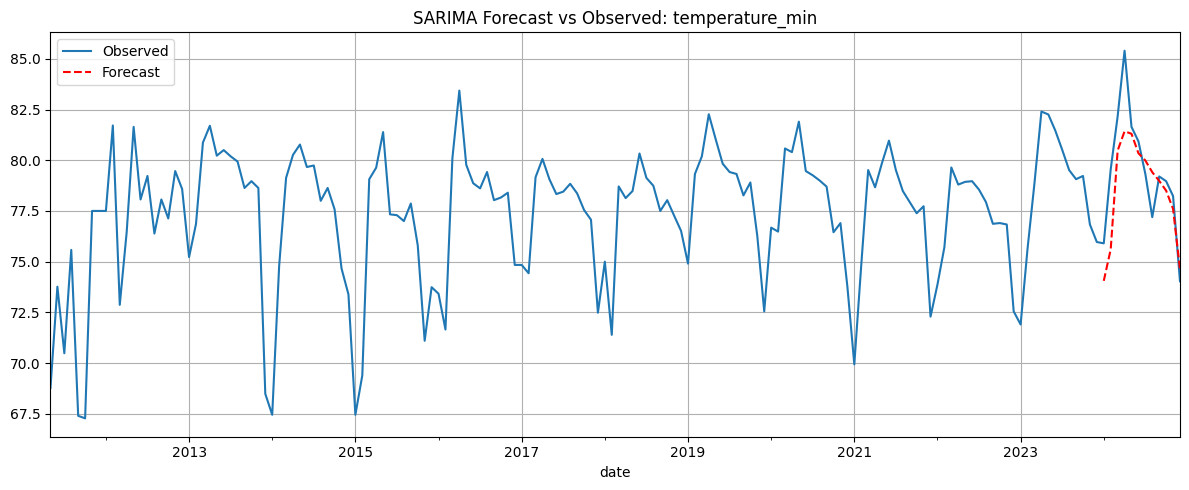

Forecasted values for temperature_min:
2024-01-01    74.055090
2024-02-01    75.607799
2024-03-01    80.473385
2024-04-01    81.428704
2024-05-01    81.304838
2024-06-01    80.345776
2024-07-01    79.987011
2024-08-01    79.408939
2024-09-01    78.983647
2024-10-01    78.499877
2024-11-01    77.599183
2024-12-01    74.617064
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for temperature_min:
MAE  : 1.430
RMSE : 1.924
MAPE : 1.78%
R²   : 0.549


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


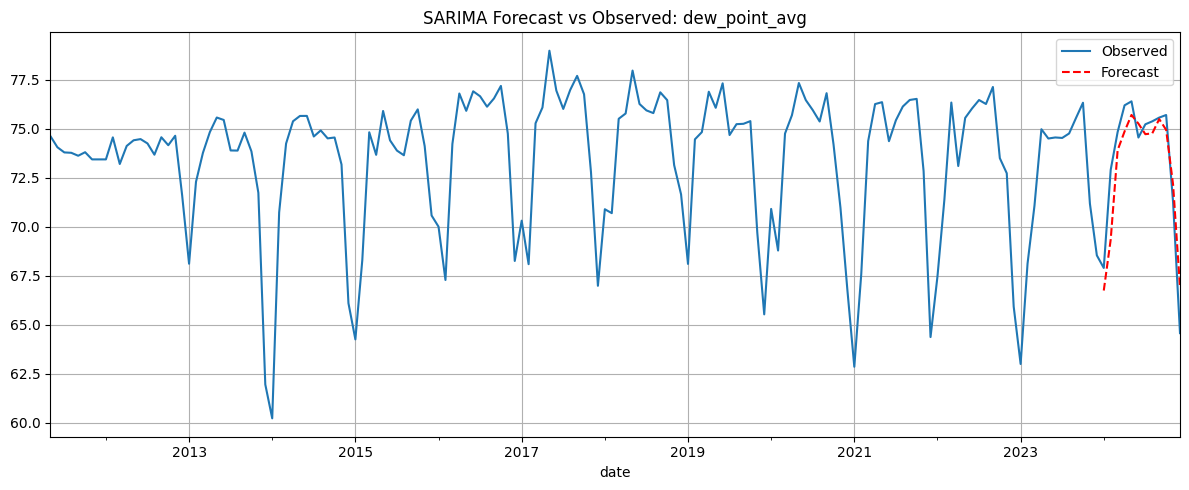

Forecasted values for dew_point_avg:
2024-01-01    66.754458
2024-02-01    69.357049
2024-03-01    73.917190
2024-04-01    74.872359
2024-05-01    75.715977
2024-06-01    75.271823
2024-07-01    74.733500
2024-08-01    74.776963
2024-09-01    75.504078
2024-10-01    74.956163
2024-11-01    72.166671
2024-12-01    66.929126
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for dew_point_avg:
MAE  : 1.131
RMSE : 1.447
MAPE : 1.57%
R²   : 0.833


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


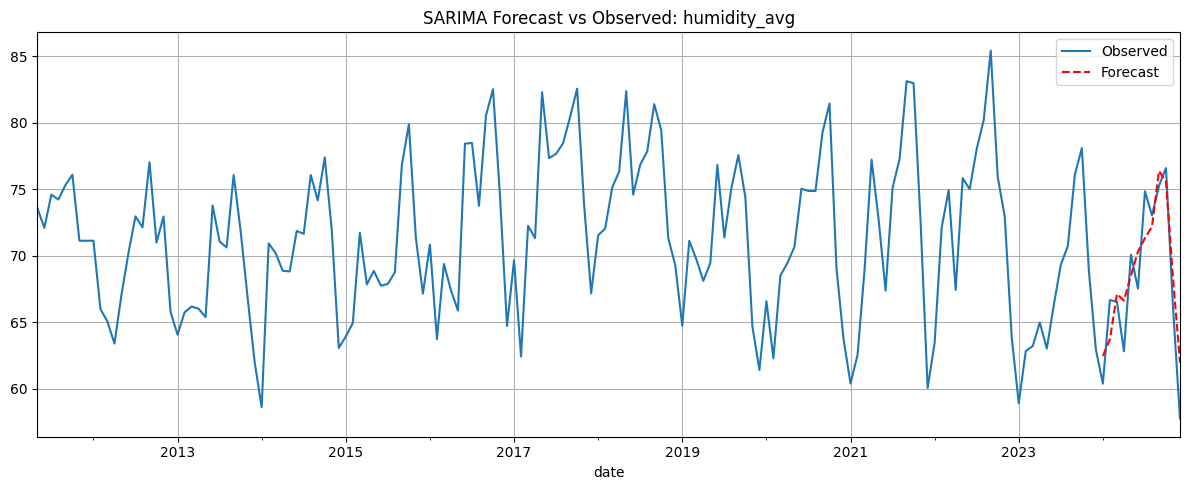

Forecasted values for humidity_avg:
2024-01-01    62.484817
2024-02-01    63.716142
2024-03-01    67.131172
2024-04-01    66.641146
2024-05-01    68.508541
2024-06-01    70.323820
2024-07-01    71.336566
2024-08-01    72.179952
2024-09-01    76.386326
2024-10-01    75.583529
2024-11-01    68.352143
2024-12-01    61.977386
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for humidity_avg:
MAE  : 2.227
RMSE : 2.519
MAPE : 3.38%
R²   : 0.809


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


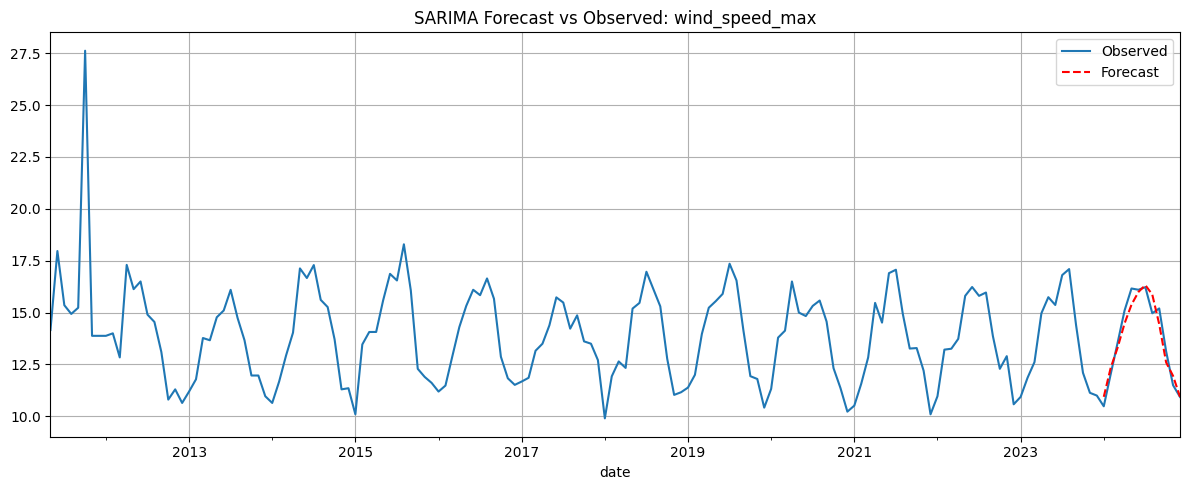

Forecasted values for wind_speed_max:
2024-01-01    10.940374
2024-02-01    12.338114
2024-03-01    13.311821
2024-04-01    14.477808
2024-05-01    15.382335
2024-06-01    15.993649
2024-07-01    16.323211
2024-08-01    15.869248
2024-09-01    14.441788
2024-10-01    12.597114
2024-11-01    11.948133
2024-12-01    10.939399
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for wind_speed_max:
MAE  : 0.437
RMSE : 0.520
MAPE : 3.15%
R²   : 0.935


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


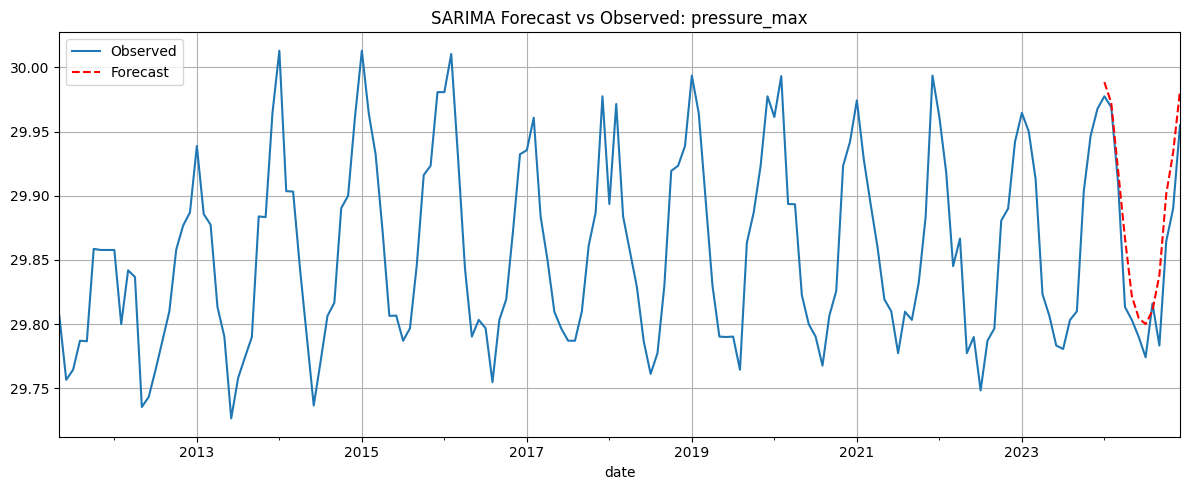

Forecasted values for pressure_max:
2024-01-01    29.988490
2024-02-01    29.972305
2024-03-01    29.919500
2024-04-01    29.866671
2024-05-01    29.821694
2024-06-01    29.804778
2024-07-01    29.799966
2024-08-01    29.810697
2024-09-01    29.837996
2024-10-01    29.901259
2024-11-01    29.933580
2024-12-01    29.981645
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for pressure_max:
MAE  : 0.025
RMSE : 0.031
MAPE : 0.08%
R²   : 0.822


In [24]:
# Loop through each feature in the feature_list to apply the SARIMA procedure
for feature in feature_list:
    # Apply all the previous steps inside this loop for each feature
    y = bkk_pm_filled[feature].dropna()
    
    if not isinstance(y.index, pd.DatetimeIndex):
        y.index = pd.to_datetime(bkk_pm_filled.loc[y.index, "date"])

    # Train-test split
    y_train = y[:-forecast_steps]
    y_test = y[-forecast_steps:]
    
    # Fit SARIMA model
    model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    
    # Generate forecast
    forecast = result.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_index = pd.date_range(start=y_train.index[-1] + pd.offsets.MonthBegin(1),
                                   periods=forecast_steps, freq='MS')
    forecast_mean.index = forecast_index
    y_test.index = forecast_index

    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 5))
    y.plot(ax=ax, label='Observed')
    forecast_mean.plot(ax=ax, label='Forecast', color='red', style='--')
    ax.set_title(f'SARIMA Forecast vs Observed: {feature}')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print forecasted values
    print(f"Forecasted values for {feature}:")
    print(forecast_mean)
    
    # Calculate and print accuracy metrics
    mae = mean_absolute_error(y_test, forecast_mean)
    rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
    mape = mean_absolute_percentage_error(y_test, forecast_mean)
    r2 = r2_score(y_test, forecast_mean)
    
    print(f"Forecast Accuracy Metrics for {feature}:")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.3f}")


Stationarity check for temperature_min:
ADF Statistic: -2.850
p-value: 0.051
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Forecasted values for temperature_min:
             Forecast   Lower CI   Upper CI
2025-01-01  74.055090  70.582055  77.528124
2025-02-01  75.607799  71.893627  79.321971
2025-03-01  80.473385  76.688388  84.258382
2025-04-01  81.428704  77.601206  85.256203
2025-05-01  81.304838  77.445800  85.163876
2025-06-01  80.345776  76.453538  84.238014
2025-07-01  79.987011  76.062101  83.911922
2025-08-01  79.408939  75.451678  83.366201
2025-09-01  78.983647  74.994311  82.972984
2025-10-01  78.499877  74.478724  82.521031
2025-11-01  77.599183  73.546455  81.651912
2025-12-01  74.617064  70.532938  78.701190
Precision Metrics for forecast:
MAE  : 1.430
RMSE : 1.924
MAPE : 1.78%
R²   : 0.549


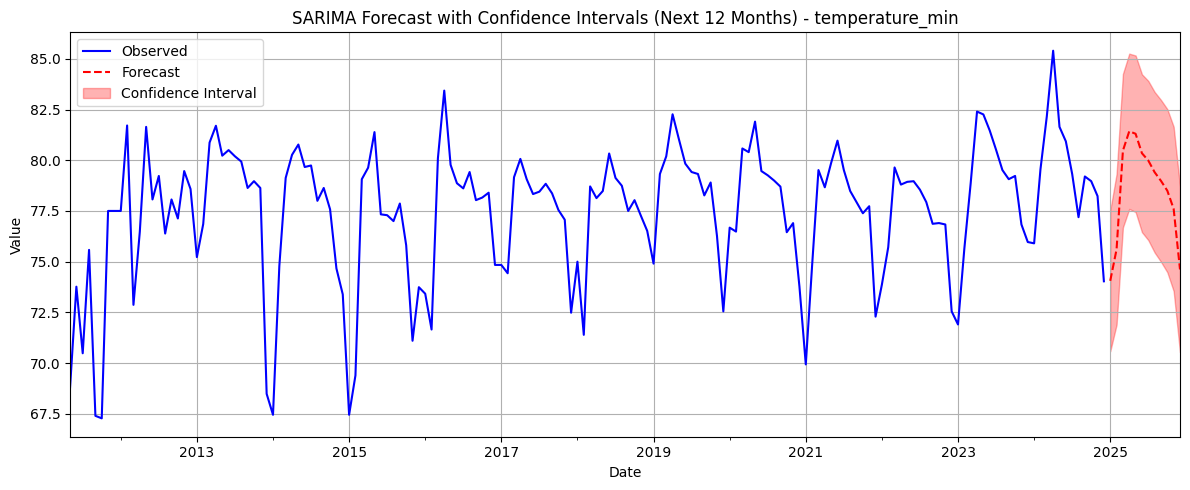

Stationarity check for dew_point_avg:
ADF Statistic: -2.161
p-value: 0.221
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Forecasted values for dew_point_avg:
             Forecast   Lower CI   Upper CI
2025-01-01  66.754458  63.219327  70.289589
2025-02-01  69.357049  65.650541  73.063557
2025-03-01  73.917190  70.160871  77.673509
2025-04-01  74.872359  71.082232  78.662486
2025-05-01  75.715977  71.899705  79.532250
2025-06-01  75.271823  71.426561  79.117084
2025-07-01  74.733500  70.859315  78.607685
2025-08-01  74.776963  70.873931  78.679995
2025-09-01  75.504078  71.572386  79.435770
2025-10-01  74.956163  70.996014  78.916313
2025-11-01  72.166671  68.178253  76.155088
2025-12-01  66.929126  62.912536  70.945716
Precision Metrics for forecast:
MAE  : 1.131
RMSE : 1.447
MAPE : 1.57%
R²   : 0.833


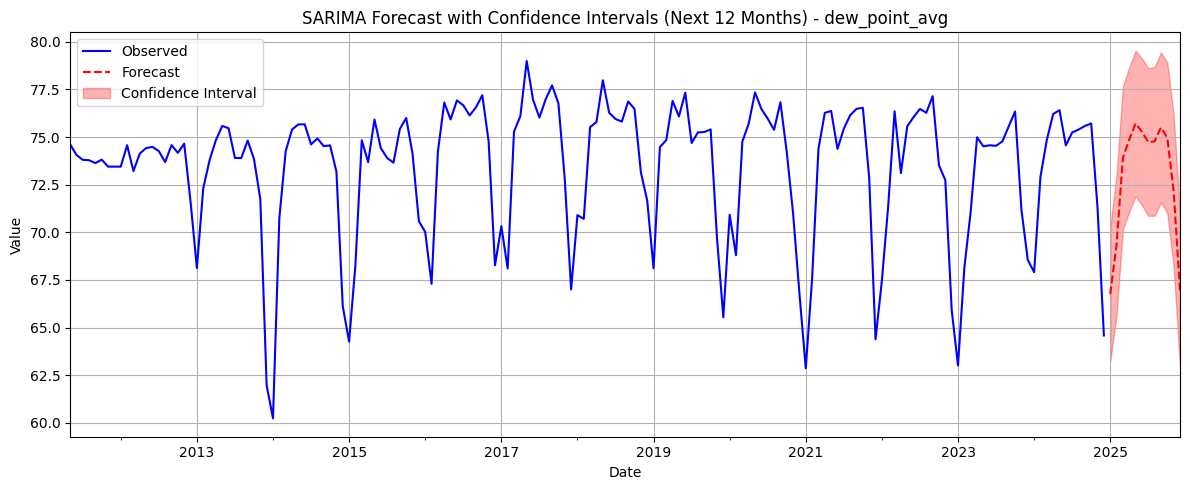

Stationarity check for humidity_avg:
ADF Statistic: -1.650
p-value: 0.457
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Forecasted values for humidity_avg:
             Forecast   Lower CI   Upper CI
2025-01-01  62.484817  55.391281  69.578353
2025-02-01  63.716142  56.105437  71.326846
2025-03-01  67.131172  59.300638  74.961706
2025-04-01  66.641146  58.639387  74.642904
2025-05-01  68.508541  60.349358  76.667723
2025-06-01  70.323820  62.015426  78.632213
2025-07-01  71.336566  62.878340  79.794792
2025-08-01  72.179952  63.574252  80.785652
2025-09-01  76.386326  67.635205  85.137447
2025-10-01  75.583529  66.689117  84.477942
2025-11-01  68.352143  59.316358  77.387929
2025-12-01  61.977386  52.801480  71.153293
Precision Metrics for forecast:
MAE  : 2.227
RMSE : 2.519
MAPE : 3.38%
R²   : 0.809


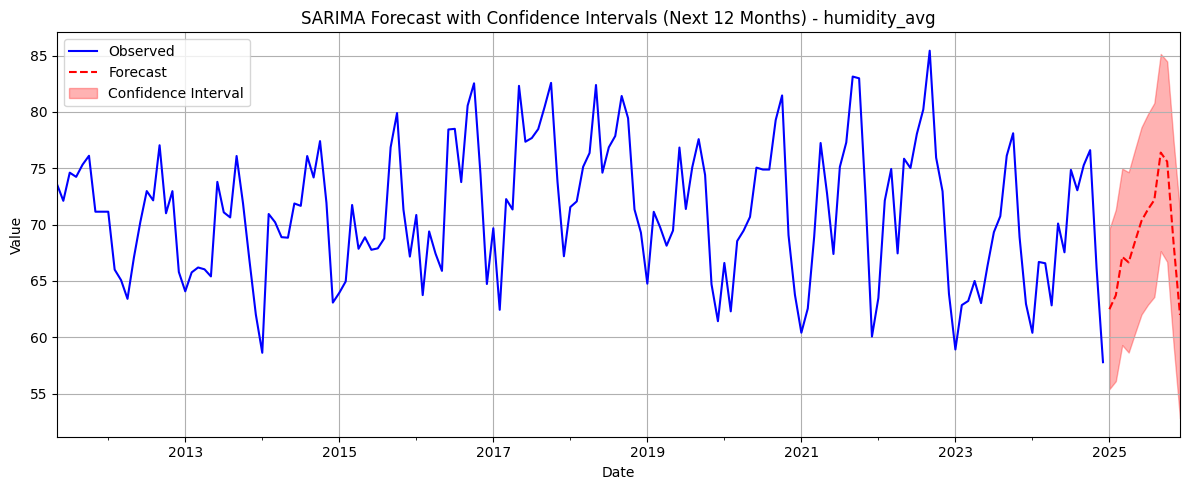

Stationarity check for wind_speed_max:
ADF Statistic: -12.353
p-value: 0.000
Critical Values:
   1%: -3.472
   5%: -2.880
   10%: -2.577
Stationary: Yes


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Forecasted values for wind_speed_max:
             Forecast   Lower CI   Upper CI
2025-01-01  10.978943   9.358067  12.599819
2025-02-01  12.295817  10.597710  13.993925
2025-03-01  13.322270  11.623983  15.020557
2025-04-01  14.389479  12.691532  16.087425
2025-05-01  15.379344  13.684902  17.073786
2025-06-01  16.001783  14.307341  17.696225
2025-07-01  16.276582  14.582142  17.971023
2025-08-01  15.806891  14.112450  17.501332
2025-09-01  14.477402  12.782961  16.171842
2025-10-01  12.596854  10.902413  14.291295
2025-11-01  11.924463  10.230022  13.618904
2025-12-01  10.982645   9.288205  12.677086
Precision Metrics for forecast:
MAE  : 0.432
RMSE : 0.515
MAPE : 3.13%
R²   : 0.936


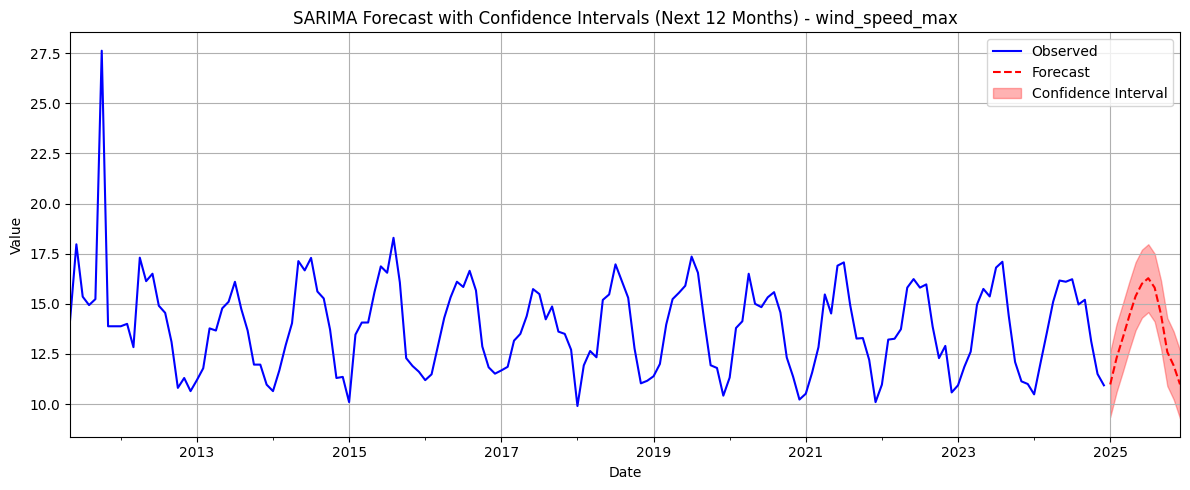

Stationarity check for pressure_max:
ADF Statistic: -2.300
p-value: 0.172
Critical Values:
   1%: -3.474
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Forecasted values for pressure_max:
             Forecast   Lower CI   Upper CI
2025-01-01  29.988490  29.938064  30.038916
2025-02-01  29.972305  29.921190  30.023420
2025-03-01  29.919500  29.866725  29.972276
2025-04-01  29.866671  29.812416  29.920925
2025-05-01  29.821694  29.766061  29.877327
2025-06-01  29.804778  29.747735  29.861821
2025-07-01  29.799966  29.741548  29.858385
2025-08-01  29.810697  29.750934  29.870460
2025-09-01  29.837996  29.776919  29.899073
2025-10-01  29.901259  29.838895  29.963624
2025-11-01  29.933580  29.869955  29.997205
2025-12-01  29.981645  29.916784  30.046507
Precision Metrics for forecast:
MAE  : 0.025
RMSE : 0.031
MAPE : 0.08%
R²   : 0.822


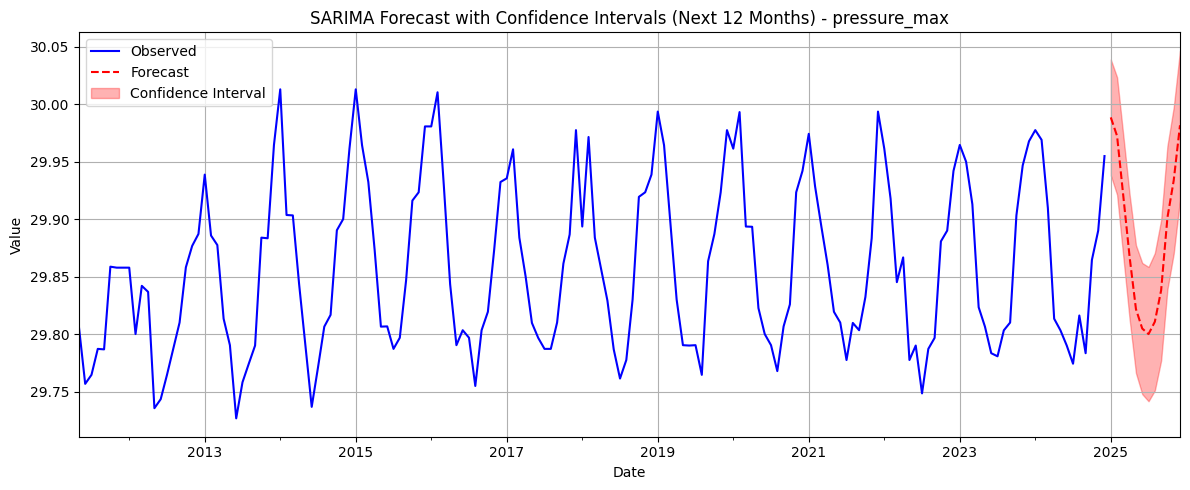

In [29]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to perform the Dickey-Fuller test and inspect stationarity
def check_stationarity(y):
    result = adfuller(y)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    
    # Interpretation based on p-value
    if result[1] < 0.05:
        print("Stationary: Yes")
        return True  # Stationary
    else:
        print("Stationary: No")
        return False  # Non-stationary

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Forecast horizon
forecast_steps = 12

# Loop through each feature to apply the SARIMA procedure and check stationarity
for feature in feature_list:
    # Drop NA values for the current feature
    y = bkk_pm_filled[feature].dropna()
    
    # Ensure the data has a datetime index
    if not isinstance(y.index, pd.DatetimeIndex):
        y.index = pd.to_datetime(bkk_pm_filled.loc[y.index, "date"])

    # Check stationarity of the feature
    print(f"Stationarity check for {feature}:")
    is_stationary = check_stationarity(y)
    print("="*50)  # Separator for clarity
    
    # Dynamically set the 'd' value based on stationarity
    d = 0 if is_stationary else 1
    
    # Train-test split
    y_train = y[:-forecast_steps]
    y_test = y[-forecast_steps:]

    # Define SARIMA order (p, d, q) and seasonal order (P, D, Q, s)
    sarima_order = (1, d, 1)  # Set d based on stationarity check
    seasonal_order = (1, 1, 1, 12)  # P, D, Q, s (12 for monthly data with yearly seasonality)

    # Fit SARIMA model
    model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    # Generate forecast
    forecast = result.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Create index for forecast
    forecast_index = pd.date_range(start=y.index[-1] + pd.offsets.MonthBegin(1),
                                   periods=forecast_steps, freq='MS')
    forecast_mean.index = forecast_index
    forecast_ci.index = forecast_index

    # Combine into DataFrame
    forecast_df = pd.DataFrame({
        "Forecast": forecast_mean,
        "Lower CI": forecast_ci.iloc[:, 0],
        "Upper CI": forecast_ci.iloc[:, 1]
    })

    # Show the DataFrame
    print(f"Forecasted values for {feature}:")
    print(forecast_df)

    # Calculate precision metrics
    mae = mean_absolute_error(y_test, forecast_mean)
    rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
    mape = mean_absolute_percentage_error(y_test, forecast_mean)
    r2 = r2_score(y_test, forecast_mean)

    # Print precision metrics
    print("Precision Metrics for forecast:")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.3f}")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot the observed data
    y.plot(ax=ax, label='Observed', color='blue')

    # Plot the forecasted values
    forecast_mean.plot(ax=ax, label='Forecast', color='red', style='--')

    # Fill the confidence intervals
    ax.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'],
                    color='red', alpha=0.3, label='Confidence Interval')

    # Set plot title and labels
    ax.set_title(f'SARIMA Forecast with Confidence Intervals (Next 12 Months) - {feature}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

    # Display grid and tighten layout
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Stationarity check for temperature_min:
ADF Statistic: -2.850
p-value: 0.051
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Stationarity check for dew_point_avg:
ADF Statistic: -2.161
p-value: 0.221
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Stationarity check for humidity_avg:
ADF Statistic: -1.650
p-value: 0.457
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Stationarity check for wind_speed_max:
ADF Statistic: -12.353
p-value: 0.000
Critical Values:
   1%: -3.472
   5%: -2.880
   10%: -2.577
Stationary: Yes


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Stationarity check for pressure_max:
ADF Statistic: -2.300
p-value: 0.172
Critical Values:
   1%: -3.474
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Combined Forecast DataFrame with all features:
            temperature_min  dew_point_avg  humidity_avg  wind_speed_max  \
2025-01-01        74.055090      66.754458     62.484817       10.978943   
2025-02-01        75.607799      69.357049     63.716142       12.295817   
2025-03-01        80.473385      73.917190     67.131172       13.322270   
2025-04-01        81.428704      74.872359     66.641146       14.389479   
2025-05-01        81.304838      75.715977     68.508541       15.379344   
2025-06-01        80.345776      75.271823     70.323820       16.001783   
2025-07-01        79.987011      74.733500     71.336566       16.276582   
2025-08-01        79.408939      74.776963     72.179952       15.806891   
2025-09-01        78.983647      75.504078     76.386326       14.477402   
2025-10-01        78.499877      74.956163     75.583529       12.596854   
2025-11-01        77.599183      72.166671     68.352143       11.924463   
2025-12-01        74.617064      66.92912

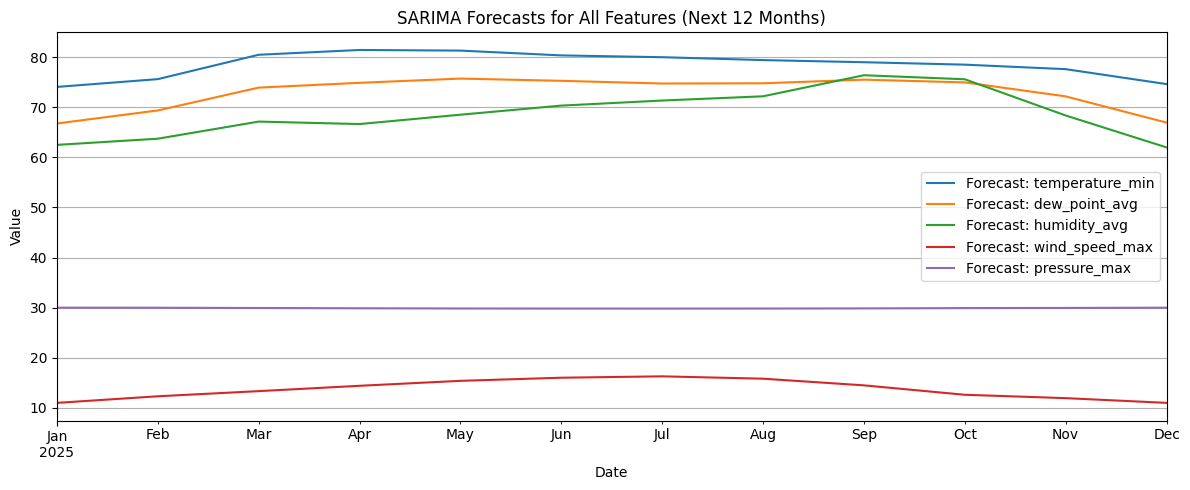

In [32]:
# Initialize an empty DataFrame to store the forecasts of all features
forecast_combined_df = pd.DataFrame()

# Forecast horizon
forecast_steps = 12

# Loop through each feature to apply the SARIMA procedure, check stationarity, and store predictions
for feature in feature_list:
    # Drop NA values for the current feature
    y = bkk_pm_filled[feature].dropna()
    
    # Ensure the data has a datetime index
    if not isinstance(y.index, pd.DatetimeIndex):
        y.index = pd.to_datetime(bkk_pm_filled.loc[y.index, "date"])

    # Check stationarity of the feature
    print(f"Stationarity check for {feature}:")
    is_stationary = check_stationarity(y)
    print("="*50)  # Separator for clarity
    
    # Dynamically set the 'd' value based on stationarity
    d = 0 if is_stationary else 1
    
    # Train-test split
    y_train = y[:-forecast_steps]
    y_test = y[-forecast_steps:]

    # Define SARIMA order (p, d, q) and seasonal order (P, D, Q, s)
    sarima_order = (1, d, 1)  # Set d based on stationarity check
    seasonal_order = (1, 1, 1, 12)  # P, D, Q, s (12 for monthly data with yearly seasonality)

    # Fit SARIMA model
    model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    # Generate forecast
    forecast = result.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean

    # Create index for forecast
    forecast_index = pd.date_range(start=y.index[-1] + pd.offsets.MonthBegin(1),
                                   periods=forecast_steps, freq='MS')
    forecast_mean.index = forecast_index

    # Add the forecast for this feature to the combined DataFrame
    forecast_combined_df[feature] = forecast_mean

# Display the combined forecast DataFrame
print("Combined Forecast DataFrame with all features:")
print(forecast_combined_df)

# Plot the combined forecasts
fig, ax = plt.subplots(figsize=(12, 5))

# Plot each feature's forecast
for feature in forecast_combined_df.columns:
    forecast_combined_df[feature].plot(ax=ax, label=f'Forecast: {feature}')

ax.set_title('SARIMA Forecasts for All Features (Next 12 Months)')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
combined_forecasts.to_csv("../../data/a1/weather_forecasts.csv", index=True)

Actually, it could be tuned p q more by watching, but i think accuracy is enough with general paramerters. so ACF and PACF I just plot just in case.

**For p (AR order):**

- Count how many significant spikes there are in the PACF before it cuts off (drops to near zero). This number would be your p value

**For q (MA order):**

- Count how many significant spikes there are in the ACF before it cuts off. This number would be your q value